<a href="https://colab.research.google.com/github/emivlp/object_detection_gemini/blob/main/object_detection_gemini_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Object Detection with Gemini API**

## **Leveraging AI for Open-Vocabulary Detection, Attribute Recognition, and Scene Understanding**

### **Introduction**

Object detection is a fundamental task in **computer vision**, enabling AI models to **identify and localize objects** within an image. This notebook demonstrates **how to use the Gemini API for object detection**, including:

🔹 **Single & Multi-Class Object Detection**

🔹 **Attribute-Based Recognition (e.g., Detecting red umbrellas, white dresses)**

🔹 **Negative Object Detection (Ensuring absent objects are not falsely identified)**

🔹 **World Knowledge for Object Identification (e.g., Recognizing Dog Breeds)**

🔹 **Reading Handwritten Text & Detecting Objects Referenced in Text**

🔹 **Spatial Reasoning & Scene Understanding**

This work showcases **how Large Vision-Language Models (VLMs) can analyze, reason, and interact** with images using advanced AI techniques.

For additional **interactive applications**, check out this **[demo](https://gemini-spatial-example.grantcuster.com/).**


## **1. Install Dependencies**

To begin, we install the **Google Generative AI package**, which includes the Gemini API.

- **We then import the required libraries:**


In [ ]:
!pip install -U -q "google-generativeai>=0.7.2"

In [ ]:
# Import required libraries
import os
import io
import json
import requests
import numpy as np
from PIL import Image, ImageDraw, ImageColor
import google.generativeai as genai
import IPython.display as display

## **2. Configure the API Key**

To use the Gemini API, we need to set up an API key. If you don’t have one, refer to the Authentication guide (Get API Key). **[Google Studio](https://aistudio.google.com/)**

In [ ]:
# Store your API key securely in an environment variable
os.environ["GEMINI_API_KEY"] = " "  # Replace with your actual API key

# Configure the Gemini API with the key
genai.configure(api_key=os.getenv("GEMINI_API_KEY"))


## **3. Load the Gemini Model**

The Gemini API provides access to different model versions. Here, we use **Gemini-1.5-flash-002**, which balances **speed and performance**.

In [ ]:
# Initialize the Generative AI model
model = genai.GenerativeModel(model_name='gemini-1.5-flash-002')

## **4. Load an Image for Object Detection**

In this section, we test **open-vocabulary object detection** by identifying objects in an image.

#### **Load the Image**

We use a **publicly available image** for this example.

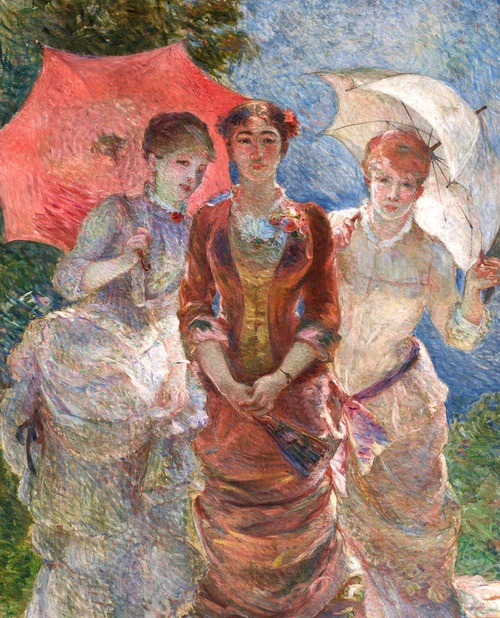

In [ ]:
# Load an image from URL
url = "https://storage.googleapis.com/generativeai-downloads/images/Marie_Bracquemond.jpeg"
response = requests.get(url)
image = Image.open(io.BytesIO(response.content))

# Display the original image in Google Colab
display.display(image)

## **5. Utility Functions for Bounding Box Visualization**

To visually **highlight detected objects**, we define a function that **draws bounding boxes**.


In [ ]:
def plot_bounding_boxes(im, noun_phrases_and_positions):
    """
    Draws bounding boxes on an image using PIL.

    Args:
        im (PIL.Image): The input image.
        noun_phrases_and_positions (list): List of tuples (label, [ymin, xmin, ymax, xmax])
                                           with normalized coordinates.

    Returns:
        PIL.Image: Image with bounding boxes drawn.
    """
    width, height = im.size
    draw = ImageDraw.Draw(im)

    # Define colors for bounding boxes
    colors = [
        'red', 'green', 'blue', 'yellow', 'orange', 'pink', 'purple',
        'brown', 'gray', 'cyan', 'magenta', 'lime', 'navy', 'olive', 'gold'
    ] + list(ImageColor.colormap.keys())

    # Iterate over detected objects
    for i, (label, (y1, x1, y2, x2)) in enumerate(noun_phrases_and_positions):
        color = colors[i % len(colors)]

        # Convert normalized coordinates (0-1000) to absolute pixel values
        abs_x1 = int(x1 / 1000 * width)
        abs_y1 = int(y1 / 1000 * height)
        abs_x2 = int(x2 / 1000 * width)
        abs_y2 = int(y2 / 1000 * height)

        # Draw bounding box
        draw.rectangle([(abs_x1, abs_y1), (abs_x2, abs_y2)], outline=color, width=3)

        # Add label
        draw.text((abs_x1 + 5, abs_y1 + 5), label, fill=color)

    return im


## **6. Run Object Detection**

We **prompt the Gemini model to detect umbrellas** in the image.

In [ ]:
# Request bounding boxes from the Gemini model
response = model.generate_content([
    image,
    (
        "Return bounding boxes for all umbrellas in the following format as a list:\n"
        "[ymin, xmin, ymax, xmax]"
    ),
])

# Print raw response to check its structure
print("Raw Response from Gemini API:")
print(response.text)

Raw Response from Gemini API:
Here are the bounding boxes for the umbrellas in the image:

- [66, 0, 426, 501]
- [100, 590, 426, 998]


### **Parse and Display the Bounding Boxes**
To process **bounding box responses**, we define a parsing function.



In [ ]:
import re
import json

def parse_list_boxes(text):
    """
    Parses bounding box coordinates from the Gemini API response.
    Handles different formats including JSON, lists, and text with bullet points.

    Args:
        text (str): Response text containing bounding box data.

    Returns:
        list: List of bounding boxes in [ymin, xmin, ymax, xmax] format.
    """
    result = []

    try:
        # Case 1: If the output is JSON (list or dictionary)
        parsed_data = json.loads(text.replace("'", '"'))
        if isinstance(parsed_data, dict):
            result = list(parsed_data.values())  # Convert dictionary to list
        elif isinstance(parsed_data, list):
            result = parsed_data  # Already in correct format
        return result

    except json.JSONDecodeError:
        pass  # Not JSON, continue with other methods

    try:
        # Case 2: If output contains bullet points with bounding boxes
        result = [
            list(map(int, box.split(',')))
            for box in re.findall(r'-\s*\[(\d+,\s*\d+,\s*\d+,\s*\d+)\]', text)
        ]
        if result:
            return result
    except:
        pass  # No match, continue

    try:
        # Case 3: If output is in English with "ymin, xmin, ymax, xmax"
        matches = re.findall(r"ymin:\s*(\d+),\s*xmin:\s*(\d+),\s*ymax:\s*(\d+),\s*xmax:\s*(\d+)", text)
        result = [[int(ymin), int(xmin), int(ymax), int(xmax)] for ymin, xmin, ymax, xmax in matches]
        if result:
            return result
    except:
        pass  # No match, continue

    return result  # If nothing is found, return an empty list


## **Extract and display bounding boxes**

Detected Bounding Boxes: [[66, 0, 426, 501], [100, 590, 426, 998]]


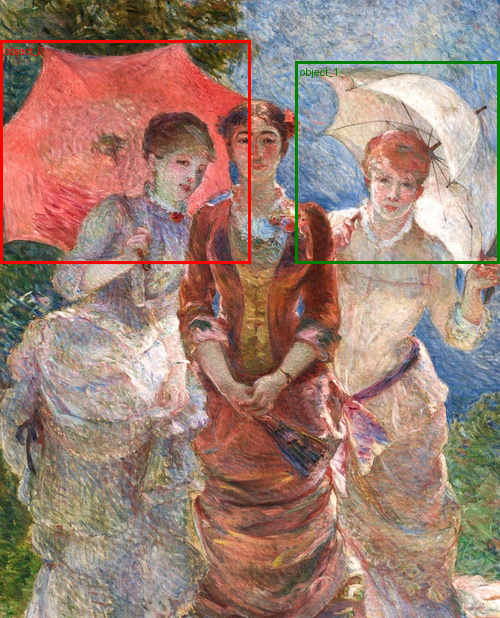

In [ ]:
# Parse bounding boxes from Gemini API
boxes = parse_list_boxes(response.text)

# Display parsed output for debugging
print("Detected Bounding Boxes:", boxes)

# Asignar etiquetas a los bounding boxes detectados
detections = [(f'object_{i}', box) for i, box in enumerate(boxes)]

# Dibujar y mostrar la imagen con bounding boxes
if detections:
    image_with_boxes = plot_bounding_boxes(image.copy(), detections)
    display.display(image_with_boxes)
else:
    print("No bounding boxes detected. Possible format mismatch.")


## **7. Region Selector (For Manual Annotation)**

To allow manual selection of bounding boxes in an interactive setting, we implement a RegionSelector utility.

Select bounding boxes manually by clicking and dragging on the image.



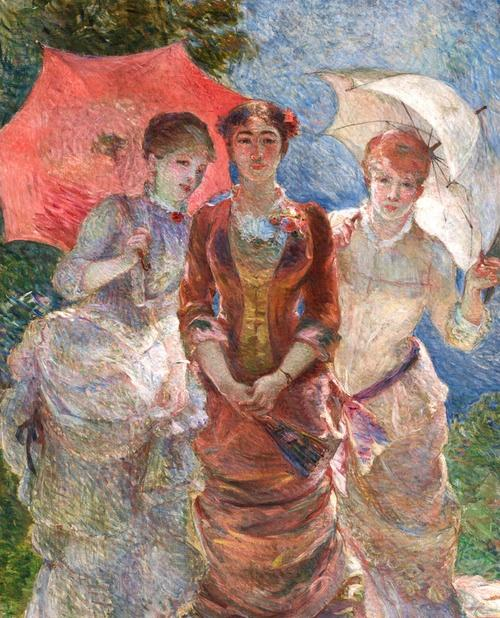

In [ ]:
import base64
import json
import io
import numpy as np
import PIL
import google.colab.output as output
import IPython
import IPython.display as display

# Global variables to store bounding boxes
bbox_str = None
bbox_hist = ''
manual_boxes = []

def set_bbox_str(x):
    """Stores manually selected bounding boxes and converts them to integer format."""
    global bbox_str, bbox_hist, manual_boxes
    try:
        bbox_str = x
        bbox_hist += x + '\n'

        # Convert string to list of integers
        bbox = json.loads(x)
        bbox = [int(coord) for coord in bbox]  # Convert all to integers

        # Append only valid bounding boxes
        if len(bbox) == 4:
            manual_boxes.append(bbox)
    except:
        print("Error processing bounding box data.")

# Register callback function in Google Colab
output.register_callback('set_bbox_str', set_bbox_str)

class RegionSelector:
    """Interactive tool for selecting bounding boxes on an image."""

    def __init__(self, img):
        src = self._img2src(img)
        IPython.display.display(IPython.display.HTML(r"""
        <img id="img" src="__SRC__">
        <pre id="pre"></pre>
        <script>
        const img = document.getElementById('img');
        const pre = document.getElementById('pre');
        let x0=null, y0=null;
        img.addEventListener('mousedown', e => {
            x0 = e.clientX;
            y0 = e.clientY;
            e.stopPropagation();
        });
        window.addEventListener('mouseup', e => {
            if (x0 === null) return;
            const bbox_str = JSON.stringify([x0, y0, e.clientX, e.clientY]);
            pre.textContent += bbox_str + '\n';
            google.colab.kernel.invokeFunction('set_bbox_str', [bbox_str], {});
            x0 = y0 = null;
            e.stopPropagation();
        });
        </script>
        """.replace('__SRC__', src)))

    def _img2src(self, img):
        """Converts an image into a base64 string for HTML rendering."""
        if isinstance(img, np.ndarray):
            img = PIL.Image.fromarray((255 * img).astype('uint8'))
        f = io.BytesIO()
        img.save(f, format='JPEG')
        s = base64.b64encode(f.getvalue()).decode('ascii')
        return 'data:image/jpg;base64,%s' % s

# Instantiate and display Region Selector
print("Select bounding boxes manually by clicking and dragging on the image.")
region_selector = RegionSelector(image)

In [ ]:
def convert_manual_boxes(manual_boxes, image):
    """
    Convert manually selected bounding boxes from pixel values to normalized coordinates.

    Args:
        manual_boxes (list): List of bounding boxes in [x1, y1, x2, y2] format.
        image (PIL.Image): The original image.

    Returns:
        list: Bounding boxes in [ymin, xmin, ymax, xmax] format.
    """
    width, height = image.size
    converted_boxes = []

    for bbox in manual_boxes:
        x1, y1, x2, y2 = bbox

        # Ensure xmin < xmax and ymin < ymax
        xmin, xmax = min(x1, x2), max(x1, x2)
        ymin, ymax = min(y1, y2), max(y1, y2)

        # Normalize coordinates to match format [ymin, xmin, ymax, xmax]
        normalized_bbox = [ymin, xmin, ymax, xmax]
        converted_boxes.append(normalized_bbox)

    return converted_boxes


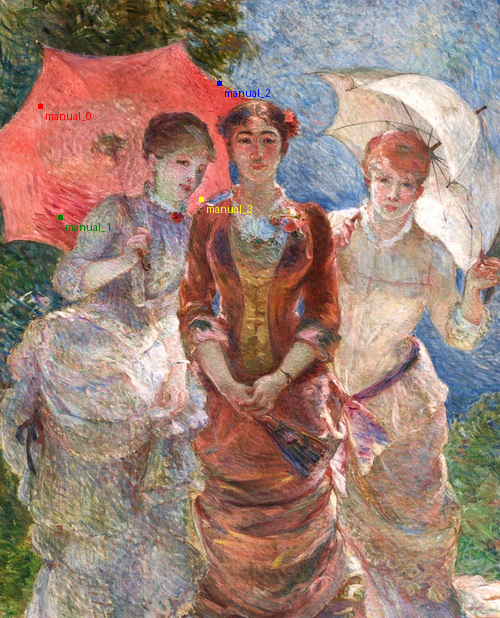

In [ ]:
# Convert manual bounding boxes
converted_manual_boxes = convert_manual_boxes(manual_boxes, image)

# Assign labels to manually drawn bounding boxes
manual_detections = [(f'manual_{i}', box) for i, box in enumerate(converted_manual_boxes)]

# Draw and display the image with manual bounding boxes
if manual_detections:
    image_with_manual_boxes = plot_bounding_boxes(image.copy(), manual_detections)
    display.display(image_with_manual_boxes)
else:
    print("No manual bounding boxes detected. Please select areas on the image.")


## **Advanced Object Detection with Gemini API**

#### **Multiclass Detection, World Knowledge & Handwritten Prompts**

This notebook extends the **Gemini-based object detection pipeline**, adding **attribute-based detection, world knowledge, and handwritten text recognition for object identification.**


In [ ]:
# Request bounding boxes from the Gemini model for multiple objects with attributes
response = model.generate_content([
    image,
    (
        "Identify the following objects in the image and return their bounding boxes:\n"
        "- Red umbrellas\n"
        "- People wearing white dresses\n"
        "- Dogs (only if present, otherwise exclude them from the response)\n"
        "Format the output as a dictionary where the key is the object name and the value "
        "is the bounding box coordinates in [ymin, xmin, ymax, xmax] format.\n"
        "Ensure only existing objects are returned."
    ),
])

# Print raw response to check its structure
print("Raw Response from Gemini API:")
print(response.text)


Raw Response from Gemini API:
{
  "Red umbrellas": [66,0,409,491],
  "People wearing white dresses": [171,658,999,999]
}


### **Parse and Visualize the Detected Objects**

Since your parse_list_boxes function only extracts coordinate lists, we need a function that handles labeled outputs (dictionaries) from Gemini.

- **Modified Parsing Function for Labeled Bounding Boxes**

In [ ]:
def parse_list_boxes_with_label(text):
    """
    Parses labeled bounding box coordinates from the Gemini API response.

    Args:
        text (str): Response text containing bounding box data.

    Returns:
        dict: Dictionary of labeled bounding boxes.
    """
    try:
        return json.loads(text.replace("'", '"'))  # Convert JSON string to dictionary
    except json.JSONDecodeError:
        print("Error: Could not parse bounding box response.")
        return {}

# Parse bounding boxes
boxes = parse_list_boxes_with_label(response.text)

# Display parsed output for debugging
print("Parsed Bounding Boxes:", boxes)


Parsed Bounding Boxes: {'Red umbrellas': [66, 0, 409, 491], 'People wearing white dresses': [171, 658, 999, 999]}


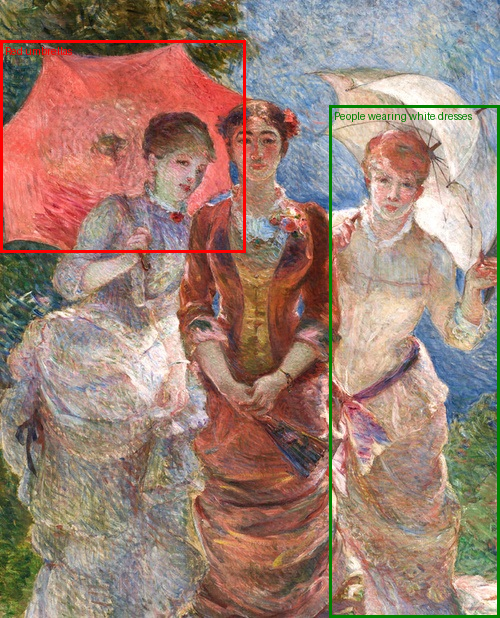

In [ ]:
# Convert dictionary into a list of tuples for visualization
detections = [(label, box) for label, box in boxes.items()]

# Draw and display the image with bounding boxes
if detections:
    image_with_boxes = plot_bounding_boxes(image.copy(), detections)
    display.display(image_with_boxes)
else:
    print("No bounding boxes detected. Possible format mismatch.")


## **Final Summary & Key Takeaways**

This notebook successfully demonstrates **Object Detection with Gemini API** using **Open-Vocabulary Vision-Language Models (VLMs)**.

🔹 **Object Detection in Various Scenarios**
✔ Open-vocabulary object detection
✔ Multi-class detection with attribute filtering (e.g., red umbrellas, white dresses)
✔ Negative detection (ensuring absent objects are ignored)

🔹 **Advanced AI Capabilities**
✔ World Knowledge Integration (Identifying dog breeds)
✔ Handwritten Text-Based Object Detection
✔ Spatial Reasoning & Scene Understanding

🔹 **Applications in Real-World Use Cases**
✔ Automated object counting and classification
✔ AI-powered visual question answering (VQA)
✔ Security & surveillance analysis
✔ Retail and e-commerce product recognition

**Future Enhancements:**

- Combine Gemini’s Vision API with object tracking for real-time applications.
- Extend VQA (Visual Question Answering) capabilities for deeper scene understanding.
- Explore text-conditioned object retrieval (e.g., “Find the blue backpack in the image”).

What’s Next?
To continue exploring object detection and scene reasoning, check out:

[Aishwarya Kamath's colab](https://colab.sandbox.google.com/drive/1eDvf_Ky9jLOZFShgHrm4GI-wkAaQnue6?usp=sharing) More advanced vision-language tasks.
[Alexander Chen](
https://x.com/alexanderchen/status/1796225933235417447) Insights into spatial understanding with AI.
This [interactive demo](https://gemini-spatial-example.grantcuster.com/) Real-time spatial reasoning examples.
Additionally, related image recognition and reasoning projects include:

